In [2]:
import os
import json
from PIL import Image
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog

In [8]:
def flatten_bounding_box(bbox):
    # If bbox is a list of lists, flatten it
    if isinstance(bbox[0], list):
        bbox = [item for sublist in bbox for item in sublist]
    return bbox

def clean_and_update_coco_dataset(coco_json_path, output_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    valid_image_ids = set()
    cleaned_annotations = []

    # Process annotations
    for annotation in coco_data['annotations']:
        # Check if segmentation is present and non-empty
        if "segmentation" in annotation and annotation["segmentation"]:
            # Flatten the bbox if needed
            bbox = annotation.get('bbox', None)
            if bbox:
                bbox = flatten_bounding_box(bbox)
                if isinstance(bbox, list) and len(bbox) == 4:
                    annotation['bbox'] = bbox
                    cleaned_annotations.append(annotation)
                    valid_image_ids.add(annotation['image_id'])
                else:
                    print(f"Invalid bbox format after flattening, removing: {bbox}")
            else:
                print(f"Annotation {annotation['id']} missing bbox, removing.")
        else:
            print(f"Removed annotation with missing or empty segmentation: {annotation['id']}")

    # Update the annotations with the cleaned list
    coco_data['annotations'] = cleaned_annotations

    # Save the cleaned and updated dataset to a new JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_data, f, indent=4)
    
    print(f"Cleaned and updated dataset saved to {output_json_path}")
    print(f"Total annotations after cleaning: {len(cleaned_annotations)}")

# Example usage:
# clean_and_update_coco_dataset("path/to/coco.json", "path/to/images", "path/to/cleaned_coco.json")


In [ ]:
# Paths to your COCO JSON files
train_json_path = "D:/UoL/Final Project/src/datasets/coco/train/annotations/train_coco.json"
val_json_path = "D:/UoL/Final Project/src/datasets/coco/val/annotations/val_coco.json"
test_json_path = "D:/UoL/Final Project/src/datasets/coco/test/annotations/test_coco.json"

# Clean both train and validation JSON files
clean_and_update_coco_dataset(train_json_path, "D:/UoL/Final Project/src/datasets/coco/train/annotations/train_coco_cleaned.json")
clean_and_update_coco_dataset(val_json_path, "D:/UoL/Final Project/src/datasets/coco/val/annotations/val_coco_cleaned.json")
clean_and_update_coco_dataset(test_json_path, "D:/UoL/Final Project/src/datasets/coco/test/annotations/test_coco_cleaned.json")



In [44]:
# Unregister the datasets if necessary
dataset_name_train = "my_dataset_train"
dataset_name_val = "my_dataset_val"
dataset_name_test = "my_dataset_test"

if dataset_name_train in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_train)
    MetadataCatalog.remove(dataset_name_train)

if dataset_name_val in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_val)
    MetadataCatalog.remove(dataset_name_val)

if dataset_name_test in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_test)
    MetadataCatalog.remove(dataset_name_test)

# Register the training dataset
register_coco_instances(
    dataset_name_train, 
    {}, 
    "D:/UoL/Final Project/src/datasets/coco/train/annotations/train_coco_cleaned.json", 
    "D:/UoL/Final Project/src/datasets/coco/train/images"
)

# Register the validation dataset
register_coco_instances(
    dataset_name_val, 
    {}, 
    "D:/UoL/Final Project/src/datasets/coco/val/annotations/val_coco_cleaned.json", 
    "D:/UoL/Final Project/src/datasets/coco/val/images"
)

# Register the test dataset
register_coco_instances(
    dataset_name_test, 
    {}, 
    "D:/UoL/Final Project/src/datasets/coco/test/annotations/test_coco_cleaned.json", 
    "D:/UoL/Final Project/src/datasets/coco/test/images"
)

print("Datasets registered successfully.")

Datasets registered successfully.


In [45]:
# Setup logger for Detectron2
setup_logger()

# Register your custom COCO dataset
# Replace these paths with the paths to your actual dataset
train_json_path = "D:/UoL/Final Project/src/datasets/coco/train/annotations/train_coco_cleaned.json"
train_images_path = "D:/UoL/Final Project/src/datasets/coco/train/images"
val_json_path = "D:/UoL/Final Project/src/datasets/coco/val/annotations/val_coco_cleaned.json"
val_images_path = "D:/UoL/Final Project/src/datasets/coco/val/images"

register_coco_instances("my_dataset_train", {}, train_json_path, train_images_path)
register_coco_instances("my_dataset_val", {}, val_json_path, val_images_path)

# Load the configuration and adjust it for your dataset
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Update the dataset paths and number of classes
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Update the number of classes to match your dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 15  # Replace with your actual number of classes

# Optionally load pre-trained weights from COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Training parameters
cfg.SOLVER.IMS_PER_BATCH = 8  # Adjust based on your GPU memory
cfg.SOLVER.BASE_LR = 0.00025  # Adjust the learning rate as needed
cfg.SOLVER.MAX_ITER = 100000  # Adjust the number of iterations as needed
cfg.SOLVER.STEPS = []  # Do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Increase if your GPU can handle it

# Output directory for the trained model and logs
cfg.OUTPUT_DIR = "maskRCNN/output/mask_rcnn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
# Create a trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Optional: Save metadata for later use
MetadataCatalog.get("my_dataset_train").thing_classes = ['Bone Loss', 'Restorations', 'Periapical Abnormality', 'Fracture', 'Implants', 'Prosthetics', 'Dental Caries', 'Absent Tooth', 'Impacted Tooth', 'other', 'Position', 'Root Stump', 'Altered Morphology', 'Attrition', 'Microdontia']  # Replace with your class names
MetadataCatalog.get("my_dataset_val").thing_classes = ['Bone Loss', 'Restorations', 'Periapical Abnormality', 'Fracture', 'Implants', 'Prosthetics', 'Dental Caries', 'Absent Tooth', 'Impacted Tooth', 'other', 'Position', 'Root Stump', 'Altered Morphology', 'Attrition', 'Microdontia']   # Replace with your class names


## evaluate model

In [46]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [57]:
# Create a custom data loader that only loads 100 images
test_loader = build_detection_test_loader(cfg, "my_dataset_test", num_workers=4)
limited_test_loader = iter(test_loader)
limited_test_loader = [next(limited_test_loader) for _ in range(100)]

WARNING [08/22 14:56:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [08/22 14:56:23 d2.data.datasets.coco]: D:/UoL/Final Project/src/datasets/coco/test/annotations/test_coco_cleaned.json contains 13510 annotations, but only 13467 of them match to images in the file.
[08/22 14:56:23 d2.data.datasets.coco]: Loaded 2321 images in COCO format from D:/UoL/Final Project/src/datasets/coco/test/annotations/test_coco_cleaned.json
[08/22 14:56:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/22 14:56:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/22 14:56:23 d2.data.common]: Serializing 2321 elements to byte tensors and concatenating them all ...
[08/22 14:56:23 d2.data.common]: Serialized dataset takes 4.23 MiB


In [58]:
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="maskrcnn/output/")

WARNING [08/22 14:56:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


In [60]:
from detectron2.engine import DefaultTrainer

# Assuming you have already loaded your trained model into cfg
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

results = inference_on_dataset(trainer.model, limited_test_loader, evaluator)

print(results)


[08/22 14:57:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (60, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (60,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (15, 256, 1, 

[08/22 14:58:03 d2.evaluation.evaluator]: Start inference on 100 batches
[08/22 14:58:25 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0000 s/iter. Inference: 2.0444 s/iter. Eval: 0.0124 s/iter. Total: 2.0569 s/iter. ETA=0:03:03
[08/22 14:58:31 d2.evaluation.evaluator]: Inference done 13/100. Dataloading: 0.0000 s/iter. Inference: 2.2338 s/iter. Eval: 0.0124 s/iter. Total: 2.2463 s/iter. ETA=0:03:15
[08/22 14:58:38 d2.evaluation.evaluator]: Inference done 16/100. Dataloading: 0.0000 s/iter. Inference: 2.2615 s/iter. Eval: 0.0124 s/iter. Total: 2.2741 s/iter. ETA=0:03:11
[08/22 14:58:44 d2.evaluation.evaluator]: Inference done 19/100. Dataloading: 0.0000 s/iter. Inference: 2.1998 s/iter. Eval: 0.0124 s/iter. Total: 2.2124 s/iter. ETA=0:02:59
[08/22 14:58:50 d2.evaluation.evaluator]: Inference done 22/100. Dataloading: 0.0000 s/iter. Inference: 2.1588 s/iter. Eval: 0.0125 s/iter. Total: 2.1715 s/iter. ETA=0:02:49
[08/22 14:58:56 d2.evaluation.evaluator]: Inference done 

ValueError: invalid literal for int() with base 10: 'clchi2m210001356j4rfwpipu'

In [1]:
from utils.custom_coco_evaluator import CustomCOCOEvaluator

In [2]:
# Paths to your files
gt_annotations_path = "datasets/coco/test/annotations/test_coco_cleaned.json"  # e.g., instances_test2017.json
pred_json_path = "maskrcnn/output/coco_instances_results.json" # e.g., coco_instances_results.json

# Create an instance of the evaluator
evaluator = CustomCOCOEvaluator(gt_annotations_path, pred_json_path, iou_threshold=0.5)

Skipping image ID cl9zlwn0baroc079g2ej627mr: dimensions not found
Overall Precision: 0.1040
Overall Recall: 0.0765
Overall Accuracy: 0.9958
Overall Specificity: 0.9982
Overall FPR: 0.0018
Overall FNR: 0.9235
Overall F1 Score: 0.0882
Class 'Bone Loss': Precision: 0.5597, Recall: 0.0722, Accuracy: 0.0683, Specificity: 0.0000, FPR: 1.0000, FNR: 0.9278, F1 Score: 0.1279, AP: 0.0404
Class 'Restorations': Precision: 1.0000, Recall: 0.0667, Accuracy: 0.0667, Specificity: 0.0000, FPR: 0.0000, FNR: 0.9333, F1 Score: 0.1251, AP: 0.0667
Class 'Periapical Abnormality': Precision: 0.9048, Recall: 0.0521, Accuracy: 0.0518, Specificity: 0.0000, FPR: 1.0000, FNR: 0.9479, F1 Score: 0.0986, AP: 0.0472
Class 'Fracture': Precision: 0.0582, Recall: 0.1650, Accuracy: 0.0450, Specificity: 0.0000, FPR: 1.0000, FNR: 0.8350, F1 Score: 0.0861, AP: 0.0096
Class 'Implants': Precision: 0.4474, Recall: 0.0614, Accuracy: 0.0570, Specificity: 0.0000, FPR: 1.0000, FNR: 0.9386, F1 Score: 0.1079, AP: 0.0275
Class 'Prosth

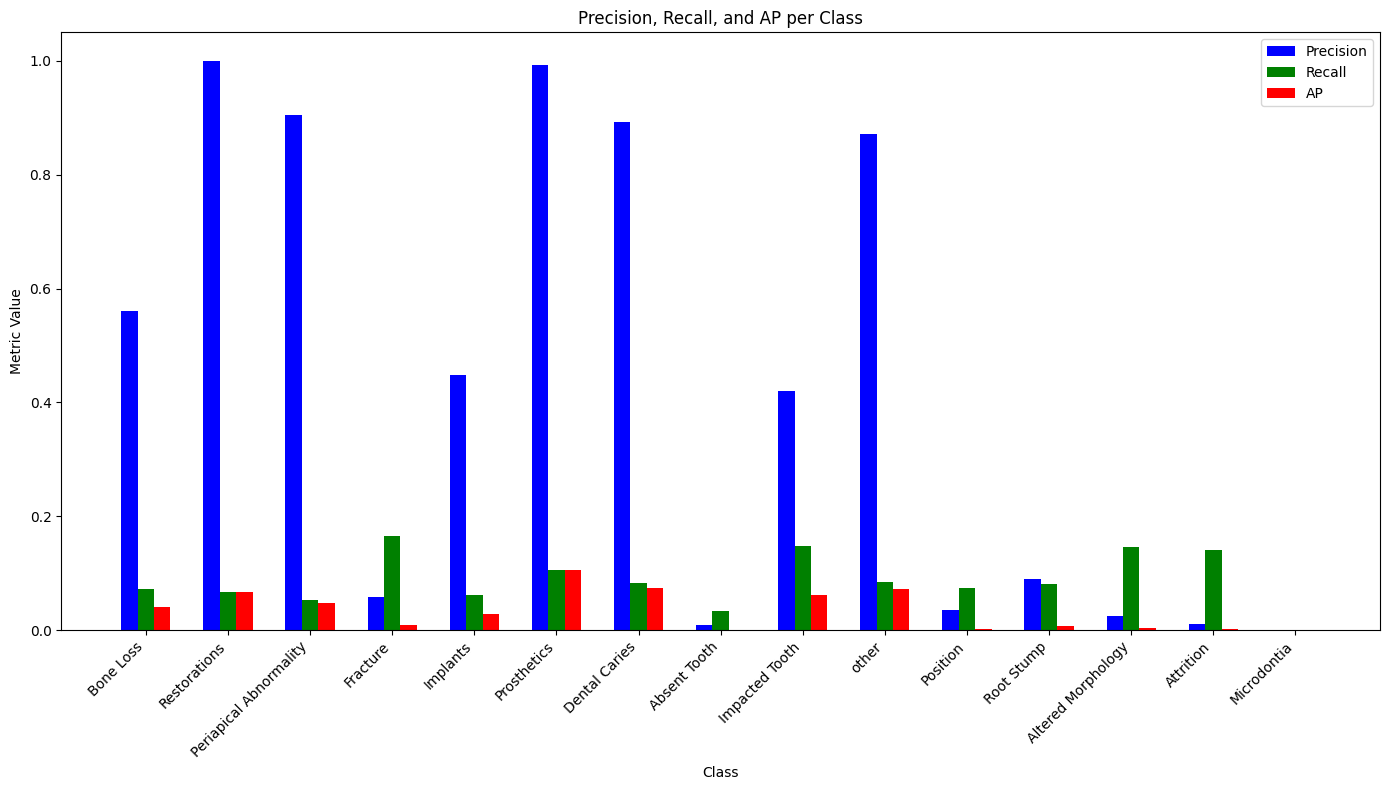

In [3]:
# Example of evaluating for bounding boxes (replace with 'segm' for segmentation masks)
precision_bbox, recall_bbox, class_metrics_bbox = evaluator.evaluate(iou_type='bbox')

# Print the overall precision and recall
print(f"Overall Precision (BBox): {precision_bbox:.4f}")
print(f"Overall Recall (BBox): {recall_bbox:.4f}")

# Visualize the per-class metrics (precision, recall, AP) for bounding boxes
evaluator.visualize_class_metrics(class_metrics_bbox)

Skipping invalid polygon due to exception: TopologyException: side location conflict at 57.5 1.2393162393162394. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception: TopologyException: side location conflict at 57.5 1.2393162393162394. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception: TopologyException: side location conflict at 57.5 1.2393162393162394. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception: TopologyException: side location conflict at 57.5 1.2393162393162394. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception: TopologyException: side location conflict at 191.3125 18.8125. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception: TopologyException: side location conflict at 191.3125 18.8125. This can occur if the input geometry is invalid.
Skipping invalid polygon due to exception:

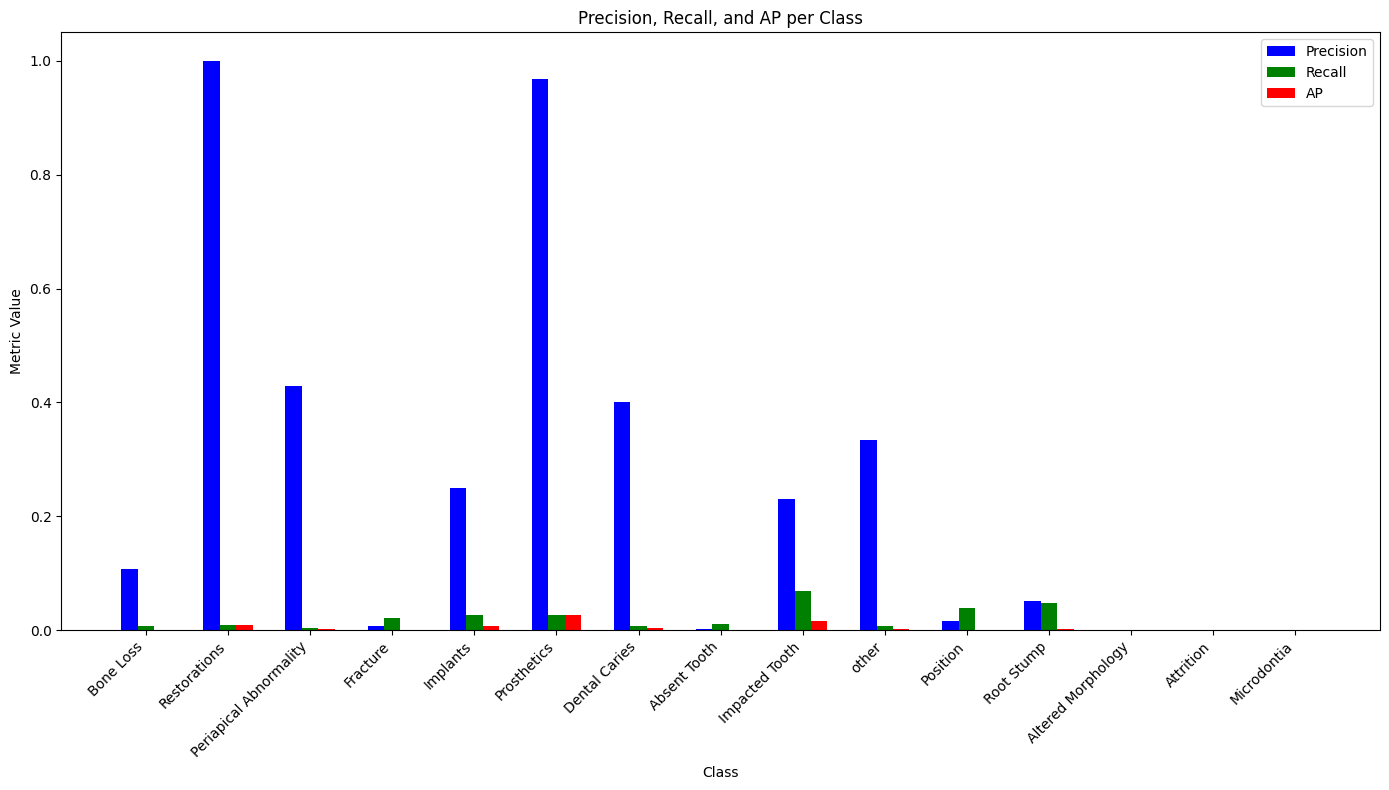

In [4]:
# Example of evaluating for segmentation masks
precision_segm, recall_segm, class_metrics_segm = evaluator.evaluate(iou_type='segm')

# Print the overall precision and recall for segmentation
print(f"Overall Precision (Segm): {precision_segm:.4f}")
print(f"Overall Recall (Segm): {recall_segm:.4f}")

# Visualize the per-class metrics (precision, recall, AP) for segmentation masks
evaluator.visualize_class_metrics(class_metrics_segm)